<a href="https://www.kaggle.com/code/matteoanzano111/hard-and-soft-clustering-of-text-data?scriptVersionId=153632980" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Linkedin job clustering and salary prediction

In this project, we will apply *clustering* to *LinkedIn* job posts. Initially, the job posts will be clustered using *k-means*, relying on *PCA* scores obtained after vectorizing the data using *TF-IDF* to find the most important words.

After clustering the job posts, we will conduct *topic modeling* on each cluster, identifying the most significant words within each cluster.

Finally, job salaries will be *predicted* based on the job posts where the salary is provided. Once this is achieved, we will extend the predictions to job posts where salary information is absent. The resulting salaries will be presented for each cluster obtained through kmeans.


In [1]:
pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=ba3ec8cec97f917ff1d3683624d0fe7f202d0207078cccaa3a7a0284e9dbb121
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


# Data cleaning

In [3]:
df=pd.read_csv("/kaggle/input/linkedin-jobs-machine-learning-data-set/LinkedInJobs_MLDataset.csv")
df.info()
df=df.loc[~df.Job_Desc.isna()]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33246 entries, 0 to 33245
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Co_Nm            33242 non-null  object 
 1   Co_Pg_Lstd       33246 non-null  bool   
 2   Emp_Cnt          33246 non-null  int64  
 3   Flw_Cnt          33246 non-null  int64  
 4   Job_Ttl          33246 non-null  object 
 5   Job_Desc         33244 non-null  object 
 6   Is_Supvsr        33246 non-null  bool   
 7   max_sal          33246 non-null  float64
 8   med_sal          33246 non-null  float64
 9   min_sal          33246 non-null  float64
 10  py_prd           33246 non-null  object 
 11  py_lstd          33246 non-null  bool   
 12  wrk_typ          33246 non-null  object 
 13  loc              33246 non-null  object 
 14  st_code          33246 non-null  object 
 15  is_remote        33246 non-null  int64  
 16  views            33246 non-null  int64  
 17  app_typ     

All the job posts that are not in english are dropped

In [4]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['Job_Desc'].split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:
            lang = "unknown"
            pass
    
    # get the language    
    languages.append(lang)
    
    
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

df['language'] = languages
df = df[df.language == 'en'] 

100%|██████████| 33244/33244 [05:39<00:00, 98.01it/s]


Total: 33244

{'da': 2,
 'de': 6,
 'en': 33201,
 'es': 15,
 'fr': 3,
 'hu': 1,
 'it': 2,
 'lt': 1,
 'nl': 2,
 'no': 1,
 'pt': 1,
 'sv': 1,
 'tl': 1,
 'tr': 2,
 'unknown': 4,
 'vi': 1}


# Hard Clustering

## Vectorization

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [6]:
text = df['Job_Desc'].values
max_features = 2**8

X = vectorize(text, max_features)

## Principal Components Analysis

*PCA* components, based on *TF-IDF* are extracted and then used in *kmeans* clustering 

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(33201, 200)

## Kmeans clustering

In [8]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 12)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

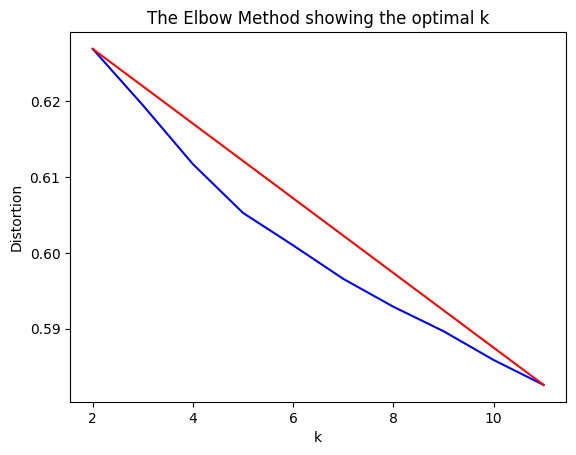

In [9]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [10]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

## t-SNE

Through *t-SNE* the data are projected in a 2 dimensional space, where is possible to view the similarity between each cluster.

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, perplexity=50, random_state=42)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

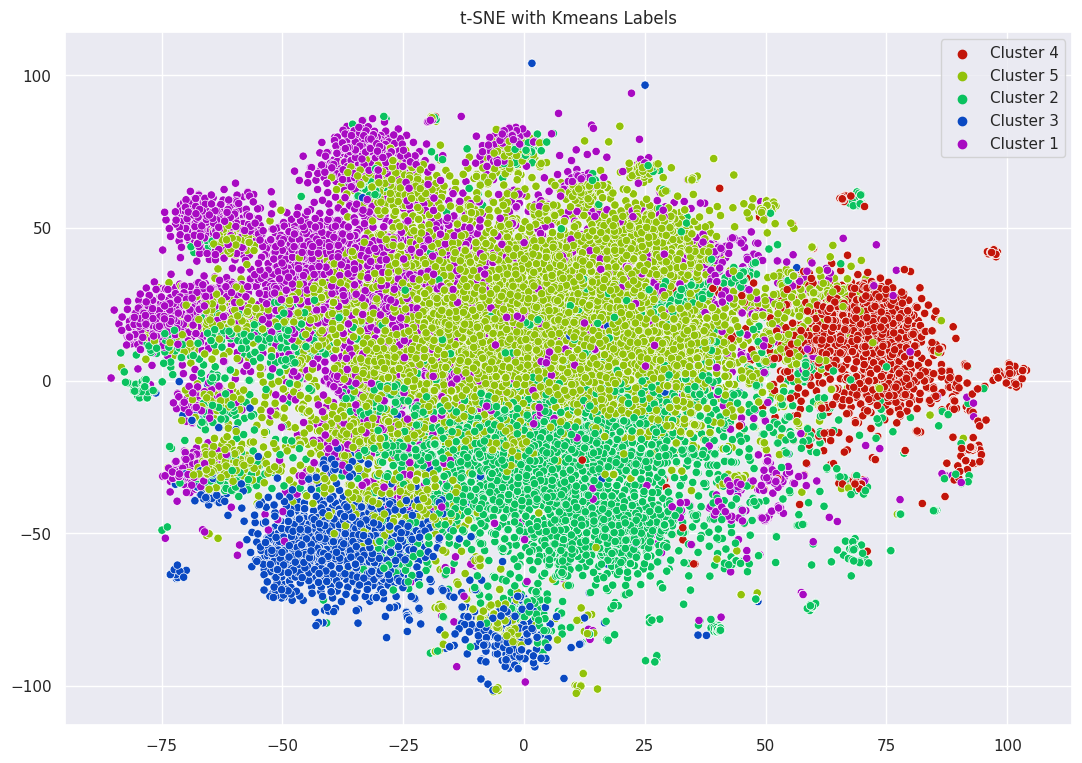

In [12]:
%matplotlib inline


# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(5, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=['Cluster '+str(x+1) for x in df.y], legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

It's observed that the clusters are partially overlapping, especially clusters 1 and 5

# Soft clustering

## Latent Dirichlet Allocation

Trough Latent Dirichlet Allocation are extracted most important words in each cluster

In [13]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [14]:
vectorizers = []
    
for ii in range(0, 5):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=10, max_df=0.8, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [15]:
vectorized_data = [] # we vectorize each cluster obtained trough kmeans

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'Job_Desc']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [16]:
NUM_TOPICS_PER_CLUSTER = 8


lda_models = []

for ii in range(0, 5):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    


In [17]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))
    
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4


In [18]:
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [19]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4


In [20]:
topics=pd.DataFrame(all_keywords).transpose().iloc[0:6,:]
topics.columns=["Cluster "+ str(x) for x in range(1,6)]

In [21]:
topics

,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
0,data,business,team,health,business
1,project,employment,service,travel,management
2,management,skills,business,medical,project
3,design,information,cogent,healthcare,equipment
4,engineering,status,bravado,required,required
5,security,role,store,services,job


It's possible to describe each cluster in this way: 
1) Technical roles

2) Business and skills

3) Teamwork

4) Healthcare

5) Management

Considering the *t-SNE* plot, there is a partial overlap between posts about *tecnical roles* and *Management roles* 

# Salary prediction

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.linear_model import Ridge
from statsmodels.graphics.mosaicplot import mosaic
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [23]:
df_sal=df.loc[df.med_sal>0]
df_sal=df_sal.loc[df_sal.py_prd=='YEARLY']
df_sal=df_sal.loc[df_sal.wrk_typ!="Volunteer"]

In this cell is made location remapping

In [24]:
# Define a function to categorize locations into broader regions based on state codes
def categorize_location(location):
    state_code = location.split(",")[-1].strip()  # Extract the state code

    # Define mappings of state codes to broader regions
    region_mapping = {
        'AL': 'South',
        'AK': 'West',
        'AZ': 'West',
        'AR': 'South',
        'CA': 'West',
        'CO': 'West',
        'CT': 'East',
        'DE': 'East',
        'FL': 'South',
        'GA': 'South',
        'HI': 'West',
        'ID': 'West',
        'IL': 'Central',
        'IN': 'Central',
        'IA': 'Central',
        'KS': 'Central',
        'KY': 'South',
        'LA': 'South',
        'ME': 'North',
        'MD': 'East',
        'MA': 'East',
        'MI': 'Central',
        'MN': 'North',
        'MS': 'South',
        'MO': 'Central',
        'MT': 'West',
        'NE': 'Central',
        'NV': 'West',
        'NH': 'North',
        'NJ': 'East',
        'NM': 'West',
        'NY': 'East',
        'NC': 'South',
        'ND': 'North',
        'OH': 'Central',
        'OK': 'Central',
        'OR': 'West',
        'PA': 'East',
        'RI': 'East',
        'SC': 'South',
        'SD': 'North',
        'TN': 'South',
        'TX': 'South',
        'UT': 'West',
        'VT': 'North',
        'VA': 'East',
        'WA': 'West',
        'WV': 'South',
        'WI': 'Central',
        'WY': 'West',
    }

    # Use the mapping or assign to 'Other' if not found
    return region_mapping.get(state_code, 'Other')

# Apply the function to create a new column with categorized locations
df_sal['Categorized_Location'] = df_sal['loc'].apply(categorize_location)
df['Categorized_Location'] = df['loc'].apply(categorize_location)

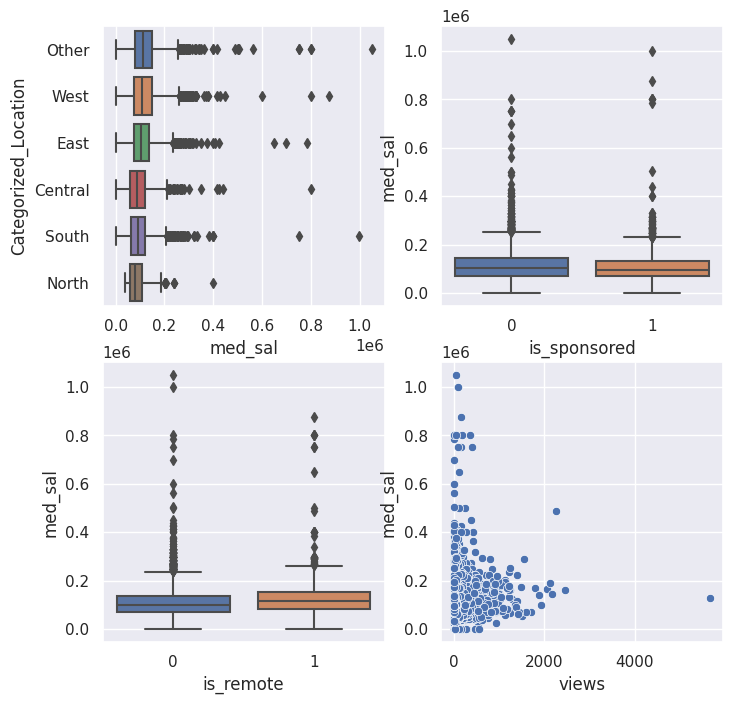

In [25]:
figure, axes = plt.subplots(2, 2, figsize=(8,8)) 
sns.boxplot(ax=axes[0,0],data=df_sal, x='med_sal', y='Categorized_Location')
sns.boxplot(ax=axes[0,1],data=df_sal, y='med_sal', x='is_sponsored')
sns.boxplot(ax=axes[1,0],data=df_sal, y='med_sal', x='is_remote')
sns.scatterplot(ax=axes[1,1],data=df_sal, y='med_sal', x='views')
plt.show()

In [26]:
target_variable='med_sal'
df_sal1=df_sal.drop(['min_sal', 'max_sal', 'domain', 'Co_Nm', 'Job_Desc', 'Job_Ttl','loc', 'py_prd','y', 'language'], axis=1)
num_vars = df_sal1.select_dtypes(include=['float64', 'int64'])
cat_vars = df_sal1.select_dtypes(include=['object', 'category'])
df_sal2 = pd.get_dummies(df_sal1, columns=cat_vars.columns)
data_X=df_sal2.drop(target_variable,axis=1) 
data_y=df_sal2[target_variable]
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, random_state = 0)
l_trainy=np.log(train_y)

In [27]:
param_grid_rf = {
    'n_estimators': [100,200,300],
    'max_features': [5,15,30,50]}

# Create the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Instantiate GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, 
                           cv=5, n_jobs=-1, verbose=0)

# Perform Grid Search to find the best parameters
grid_search_rf.fit(train_X, l_trainy)

# Best parameters and best estimator
best_params = grid_search_rf.best_params_
rf_model = grid_search_rf.best_estimator_
best_params

{'max_features': 15, 'n_estimators': 300}

In [28]:
rf_model.fit(train_X, l_trainy)
rf_pred=rf_model.predict(test_X)
rf_mape = mean_absolute_percentage_error(test_y, np.exp(rf_pred))
rf_mape

12.563828299750122

The prediction has a relative accuracy equal to 12.5%, which is good enough considering the usual salary range posted in linkedin.

In [29]:
df=df.loc[df.wrk_typ!="Volunteer"]
df1=df.drop(['min_sal', 'max_sal', 'domain', 'Co_Nm', 'Job_Desc', 'Job_Ttl','loc','py_prd', 'med_sal', 'y', 'language'], axis=1)
num_vars = df1.select_dtypes(include=['float64', 'int64'])
cat_vars = df1.select_dtypes(include=['object', 'category'])
df2 = pd.get_dummies(df1, columns=cat_vars.columns)
pred=np.exp(rf_model.predict(df2))
df['pred_salary']=pred

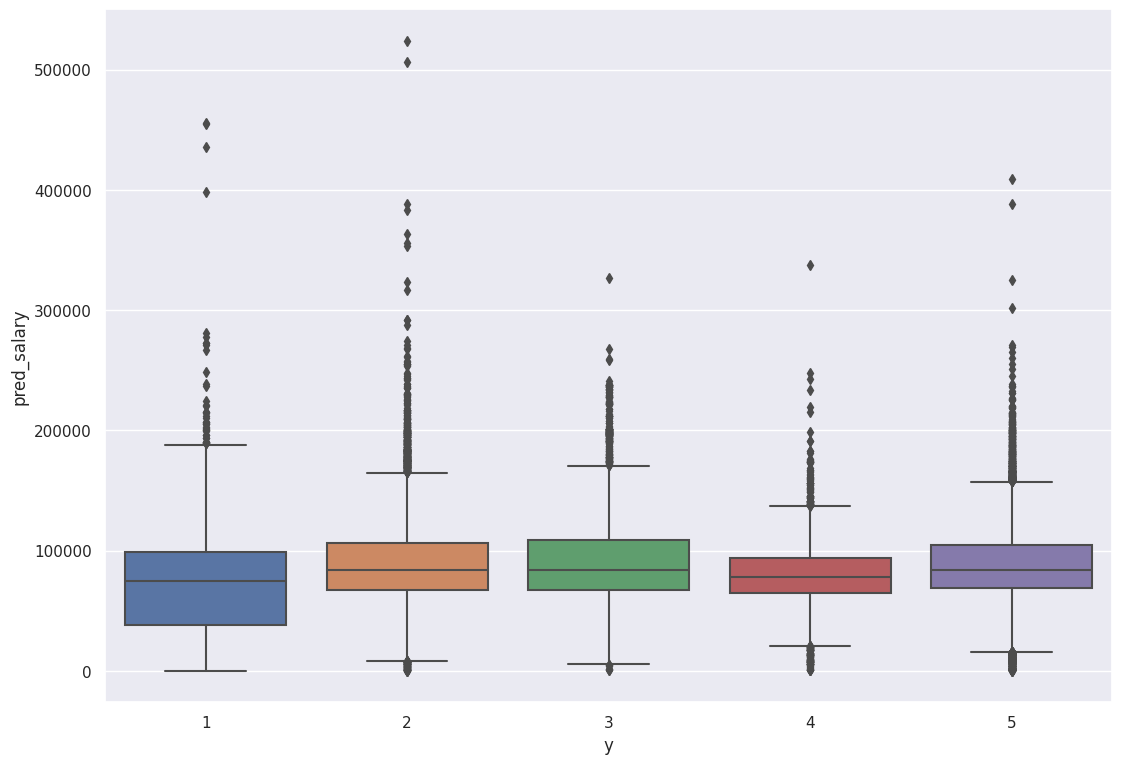

In [30]:
sns.boxplot(data=df, y=df['pred_salary'],x=df.y+1 )
plt.show()

We observe that clusters 1 and 4, which correspond to job posts related to data and healthcare, respectively, exhibit lower salaries, particularly in the case of the first cluster."